<a href="https://colab.research.google.com/github/cesaraugustt/Trabalho-ML/blob/main/Trabalho_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Machine Learning: Classificação de Pinguins Palmer

## 1. Contextualização do Dataset

### Introdução
O objetivo deste projeto é desenvolver um modelo de aprendizado de máquina capaz de classificar espécies de pinguins (Adelie, Chinstrap e Gentoo) com base em suas características físicas e geográficas.

O dataset utilizado é o **Palmer Archipelago (Antarctica) penguin data**, coletado pela Dr. Kristen Gorman e pela Estação Palmer (LTER). Ele é amplamente utilizado como uma alternativa moderna ao clássico dataset "Iris" para tarefas de classificação e visualização de dados.

### Descrição dos Dados
O conjunto de dados contém as seguintes variáveis (features):
- **species**: A espécie do pinguim (Target/Alvo).
- **island**: A ilha onde o pinguim foi encontrado (Biscoe, Dream ou Torgersen).
- **culmen_length_mm**: Comprimento do cúlmen (bico) em mm.
- **culmen_depth_mm**: Profundidade do cúlmen (bico) em mm.
- **flipper_length_mm**: Comprimento da nadadeira em mm.
- **body_mass_g**: Massa corporal em gramas.
- **sex**: Sexo do pinguim.

In [112]:
# !pip install kagglehub[pandas-datasets] --quiet
import pandas as pd
import numpy as np
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA

sns.set_style("whitegrid")

file_path = "penguins_size.csv"
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "parulpandey/palmer-archipelago-antarctica-penguin-data",
  file_path,
)

display(df.head())
df.info()

Using Colab cache for faster access to the 'palmer-archipelago-antarctica-penguin-data' dataset.


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [113]:
print("\n--- Valores únicos ---")
print(df.nunique())
print("\n--- Nulos por Coluna ---")
print(df.isnull().sum())


--- Valores únicos ---
species                3
island                 3
culmen_length_mm     164
culmen_depth_mm       80
flipper_length_mm     55
body_mass_g           94
sex                    3
dtype: int64

--- Nulos por Coluna ---
species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64


## Preparação dos Dados

In [114]:
print(df['sex'].value_counts())

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64


In [115]:
df['sex'] = df['sex'].replace('.', np.nan)

X = df.drop('species', axis=1)
y = df['species'].map({'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2})

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamanho do Treino: {X_train.shape}")
print(f"Tamanho do Teste: {X_test.shape}")

Tamanho do Treino: (275, 6)
Tamanho do Teste: (69, 6)


## Exploração e Visualização dos Dados

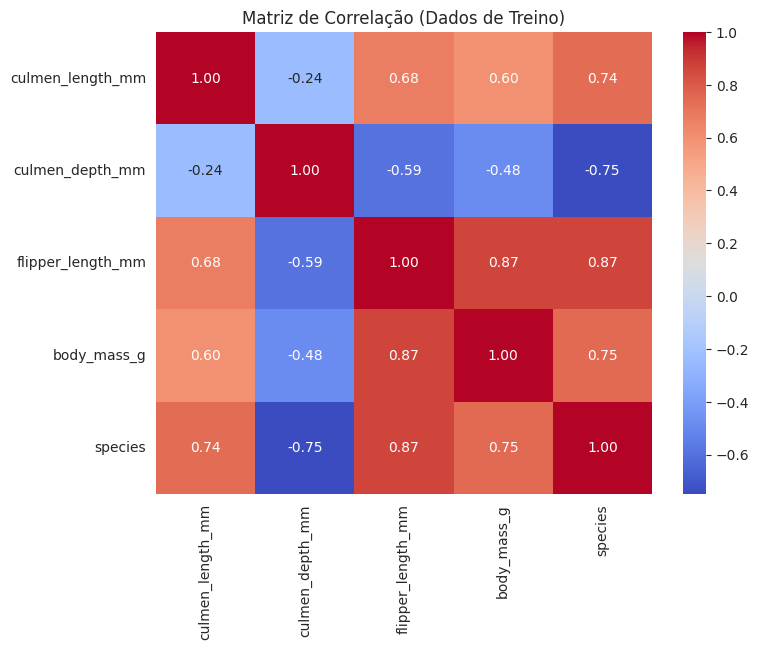

In [116]:
# Juntamos X_train e y_train temporariamente apenas para visualização
df_train_analysis = X_train.copy()
df_train_analysis['species'] = y_train

plt.figure(figsize=(8, 6))
sns.heatmap(df_train_analysis.select_dtypes(include='number').corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação (Dados de Treino)")
plt.show()

A matriz de correlação mostra que flipper_length_mm e body_mass_g possuem forte relação positiva, indicando que pinguins maiores também pesam mais. O comprimento do bico também se correlaciona moderadamente com a dimensão da barbatana. Já culmen_depth_mm apresenta correlações negativas com outras medidas, ajudando a distinguir espécies menores, como Adelie. Essas relações indicam quais variáveis são mais informativas para separação entre espécies.

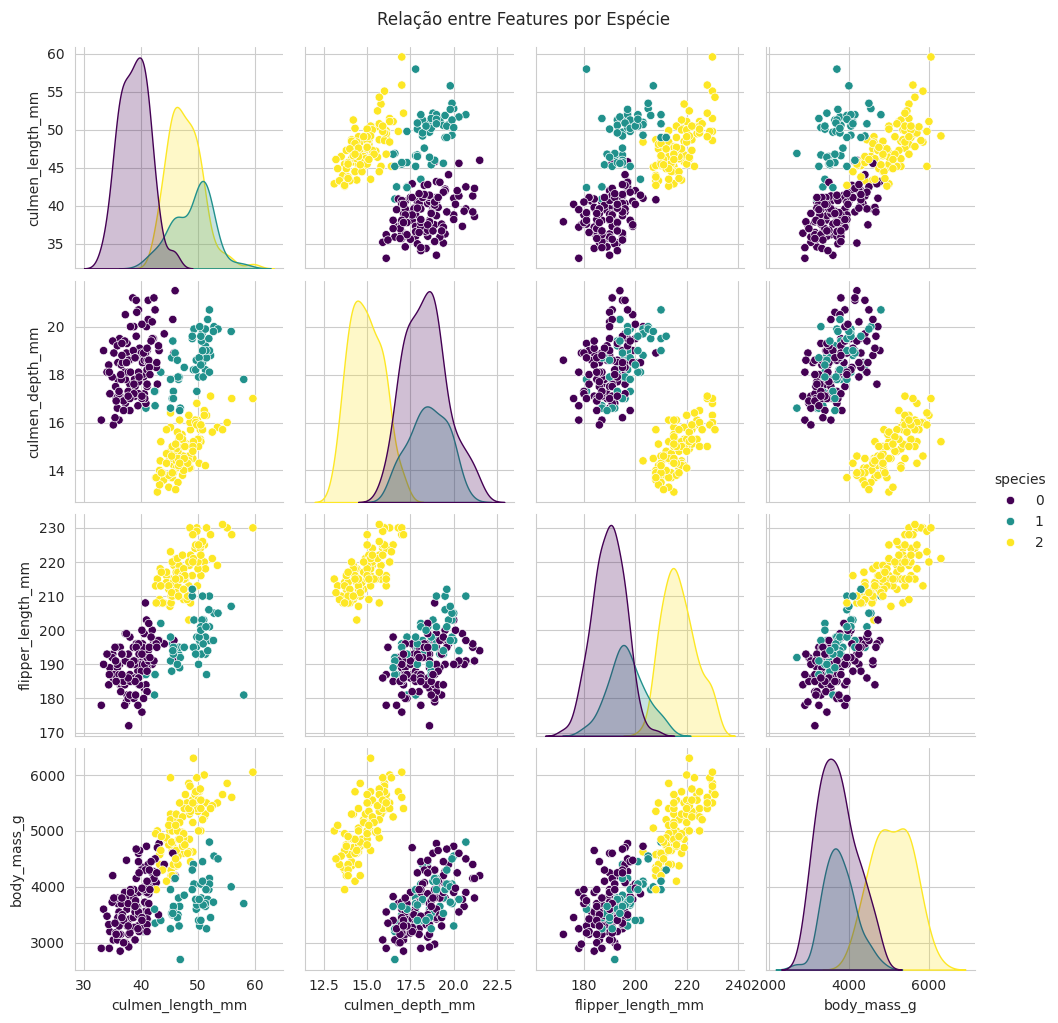

In [117]:
sns.pairplot(df_train_analysis, hue='species', palette='viridis')
plt.suptitle("Relação entre Features por Espécie", y=1.02)
plt.show()

O gráfico mostra como as medidas corporais variam entre as espécies. Pinguins Gentoo aparecem consistentemente maiores em comprimento de bico, tamanho das nadadeiras e massa corporal. Adelie formam um grupo mais compacto, com valores menores e pouca variação. Chinstrap apresentam valores intermediários e, em alguns casos, sobreposição com outras espécies. As variáveis que mais diferenciam as espécies visualmente são flipper_length_mm, body_mass_g e culmen_length_mm.

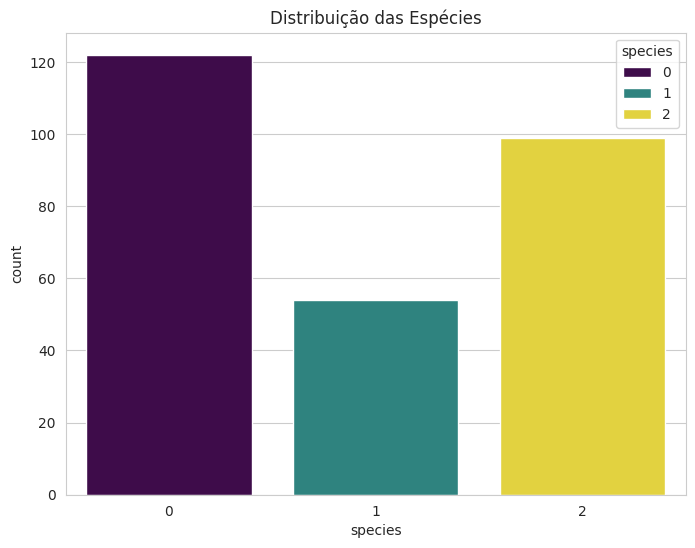

In [118]:
plt.figure(figsize=(8, 6))
sns.countplot(x='species', hue='species', data=df_train_analysis, palette='viridis')
plt.title('Distribuição das Espécies')
plt.show()

O gráfico de barras revela que a espécie Adelie é a mais numerosa no conjunto de dados, seguida pela Gentoo. A espécie Chinstrap possui a menor quantidade de registros. Apesar desse leve desbalanceamento, todas as classes têm volume suficiente para análises confiáveis e modelos de classificação.

## Aplicação das Técnicas de Aprendizado de Máquina

### Escolha dos Modelos: KNN e Random Forest

Na análise exploratória, observamos que a espécie Adelie forma grupos bem compactos, enquanto a Gentoo aparece mais isolada das demais. Esse comportamento espacial é ideal para o KNN, que funciona muito bem quando há separação visual entre os grupos.

O modelo Random Forest também é uma escolha apropriada, ao combinar várias árvores de decisão para produzir classificações mais robustas e estáveis. Percebemos que certas regras simples já separam bem as espécies, como a dimensão da nadadeira para identificar pinguins Gentoo.

In [119]:
numeric_features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
categorical_features = ['island', 'sex']

# Preenche nulos com a mediana e normaliza
numeric_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler())
])

# Preenche nulos com a moda e faz OneHot
categorical_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(
  transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
  ])

knn_pipeline = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('classifier', KNeighborsClassifier(n_neighbors=3))
])

rf_pipeline = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [120]:
def avaliar_modelo(nome, modelo, X_train, y_train, X_test, y_test, cv_folds):
  print(f"=== {nome} ===")

  scores = cross_val_score(modelo, X_train, y_train, cv=cv_folds, scoring='accuracy')
  print(f"Acurácia Média (CV): {scores.mean():.4f}")

  modelo.fit(X_train, y_train)
  y_pred = modelo.predict(X_test)

  print(f"\nRelatório de Classificação no Teste:")
  print(classification_report(y_test, y_pred))
  print("-" * 40 + "\n")

In [121]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

modelos_para_testar = [
  ("K-Nearest Neighbors", knn_pipeline),
  ("Random Forest", rf_pipeline)
]

print("--- Avaliação ---\n")

for nome_modelo, pipeline_modelo in modelos_para_testar:
  avaliar_modelo(
    nome=nome_modelo,
    modelo=pipeline_modelo,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cv_folds=cv
    )

--- Avaliação ---

=== K-Nearest Neighbors ===
Acurácia Média (CV): 0.9891

Relatório de Classificação no Teste:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.93      1.00      0.97        14
           2       1.00      1.00      1.00        25

    accuracy                           0.99        69
   macro avg       0.98      0.99      0.98        69
weighted avg       0.99      0.99      0.99        69

----------------------------------------

=== Random Forest ===
Acurácia Média (CV): 0.9818

Relatório de Classificação no Teste:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        25

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00       

In [122]:
def plot_predictions(modelo, X, y, titulo):
  plt.figure(figsize=(8, 6))

  cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
  cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])


  DecisionBoundaryDisplay.from_estimator(
    modelo, X, cmap=cmap_light, response_method="predict",
    plot_method="pcolormesh", shading="auto", alpha=0.6
  )

  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=40)
  plt.title(titulo)
  plt.xlabel("PC1")
  plt.ylabel("PC2")
  plt.show()

Gerando gráfico para Random Forest...


<Figure size 800x600 with 0 Axes>

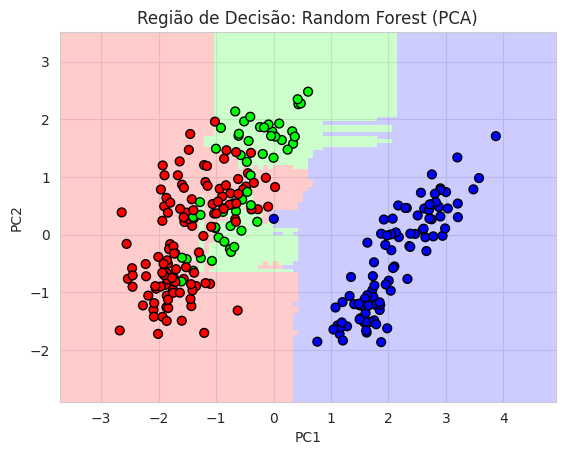

Gerando gráfico para KNN...


<Figure size 800x600 with 0 Axes>

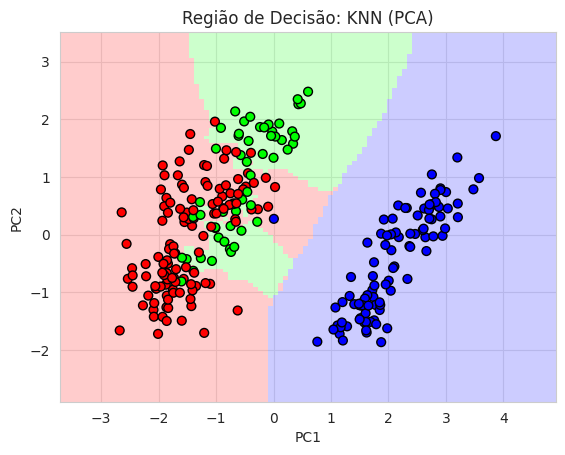

In [123]:
X_train_proc = preprocessor.fit_transform(X_train)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_proc)

print("Gerando gráfico para Random Forest...")
rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(X_train_pca, y_train)

plot_predictions(rf_pca, X_train_pca, y_train, "Região de Decisão: Random Forest (PCA)")

print("Gerando gráfico para KNN...")
knn_pca = KNeighborsClassifier(n_neighbors=3)
knn_pca.fit(X_train_pca, y_train)

plot_predictions(knn_pca, X_train_pca, y_train, "Região de Decisão: KNN (PCA)")

Os gráficos demonstram que a espécie Gentoo (azul) se separa claramente ao longo do eixo PC1, enquanto Adelie (vermelho) e Chinstrap (verde) apresentam maior sobreposição na projeção, refletindo sua similaridade morfológica observada na EDA. Apesar dessa proximidade entre as duas últimas classes, os modelos ainda estabelecem fronteiras consistentes, indicando boa capacidade de discriminação geral.